### This notebook performs burst overlap interferometry (BOI) of a stack of CSLC-S1 products within the San Joaquin Valley, CA. It calculates and plots average phase and coherence over time.

Load notebook dependencies.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os, glob
import h5py
import fsspec
import datetime
from datetime import datetime
from pyproj import Proj, CRS
import matplotlib.pyplot as plt
import shapely.wkt as wkt
from shapely import geometry, ops
import pandas as pd
import xarray as xr
import rasterio
from rasterio.crs import CRS
from rasterio.transform import from_origin
from rasterio import merge
import folium
from folium import plugins
import rioxarray
import matplotlib as mpl
import sys
sys.path.append('../../')
from src.cslc_utils import get_s3path, read_cslc, cslc_info, rasterWrite, custom_merge, colorize, getbasemaps, moving_window_mean

import warnings
warnings.filterwarnings('ignore')

We will be looking at the two overlaps between three bursts. First we get the paths of premade interferogram GeoTIFFs within the overlaps.

In [3]:
# get paths to GeoTIFFs
data_dir = '../TIFFs/ifgs/'
burst_id = ['T144_308014_IW2', 
            'T144_308015_IW2',
            'T144_308016_IW2']
topb1images = [os.path.basename(x) for x in glob.glob(f'../TIFFs/ifgs/top/IFG_{burst_id[0]}*')]
topb1images = sorted(topb1images)
topb2images = [os.path.basename(x) for x in glob.glob(f'../TIFFs/ifgs/top/IFG_{burst_id[1]}*')]
topb2images = sorted(topb2images)
botb2images = [os.path.basename(x) for x in glob.glob(f'../TIFFs/ifgs/bot/IFG_{burst_id[1]}*')]
botb2images = sorted(botb2images)
botb3images = [os.path.basename(x) for x in glob.glob(f'../TIFFs/ifgs/bot/IFG_{burst_id[2]}*')]
botb3images = sorted(botb3images)

# get list of dates
dates = [image[20:37] for image in topb1images]
dates2 = [date[9:] for date in dates]
nd = len(dates)
# convert second date in interferograms to datetime format
datesdt = []
for date in dates2:
    datesdt.append(datetime.strptime(date,'%Y%m%d'))

In [ ]:
# setup variables
topavg = np.ndarray([nd])
topcohavg = np.ndarray([nd])
botavg = np.ndarray([nd])
botcohavg = np.ndarray([nd])

for i in range(nd):
    # Read in GeoTIFFS
    # North overlap
    src = rioxarray.open_rasterio(f'{data_dir}top/{topb1images[i]}')
    topb1ifg = src.rio.reproject("EPSG:4326")[0]
    topb1ifg_cpx = np.exp(1j * np.nan_to_num(topb1ifg))
    src = rioxarray.open_rasterio(f'{data_dir}top/{topb2images[i]}')
    topb2ifg = src.rio.reproject("EPSG:4326")[0]
    topb2ifg_cpx = np.exp(1j * np.nan_to_num(topb2ifg))
    # South overlap
    src = rioxarray.open_rasterio(f'{data_dir}bot/{botb2images[i]}')
    botb2ifg = src.rio.reproject("EPSG:4326")[0]
    botb2ifg_cpx = np.exp(1j * np.nan_to_num(botb2ifg))
    src = rioxarray.open_rasterio(f'{data_dir}bot/{botb3images[i]}')
    botb3ifg = src.rio.reproject("EPSG:4326")[0]
    botb3ifg_cpx = np.exp(1j * np.nan_to_num(botb3ifg))

    # Calculate BOI
    topboi = topb1ifg_cpx*np.conj(topb2ifg_cpx)
    botboi = botb2ifg_cpx*np.conj(botb3ifg_cpx)

    # Calculate coherence and apply threshold
    window_mean = moving_window_mean(np.nan_to_num(topboi), 10)
    topcoh = np.clip(np.abs(window_mean), 0, 1)
    topcoh[np.angle(topb1ifg_cpx)==0] = 0
    window_mean = moving_window_mean(np.nan_to_num(botboi), 10)
    botcoh = np.clip(np.abs(window_mean), 0, 1)
    botcoh[np.angle(botb2ifg_cpx)==0] = 0
    topboi[topcoh<.7] = np.nan
    botboi[botcoh<.7] = np.nan
    topcoh[topcoh<.7] = np.nan
    botcoh[botcoh<.7] = np.nan

    # Take averages
    topavg[i] = np.angle(np.nanmean(topboi))
    topcohavg[i] = np.nanmean(topcoh)
    botavg[i] = np.angle(np.nanmean(botboi))
    botcohavg[i] = np.nanmean(botcoh)

Save and/or load variables.

In [ ]:
np.save('topavg.npy',topavg)
np.save('topcohavg.npy',topcohavg)
np.save('botavg.npy',botavg)
np.save('botcohavg.npy',botcohavg)

In [4]:
topavg = np.load('topavg.npy')
topcohavg = np.load('topcohavg.npy')
botavg = np.load('botavg.npy')
botcohavg = np.load('botcohavg.npy')

The following cells produce several plots visualizing average phase and coherence over time.

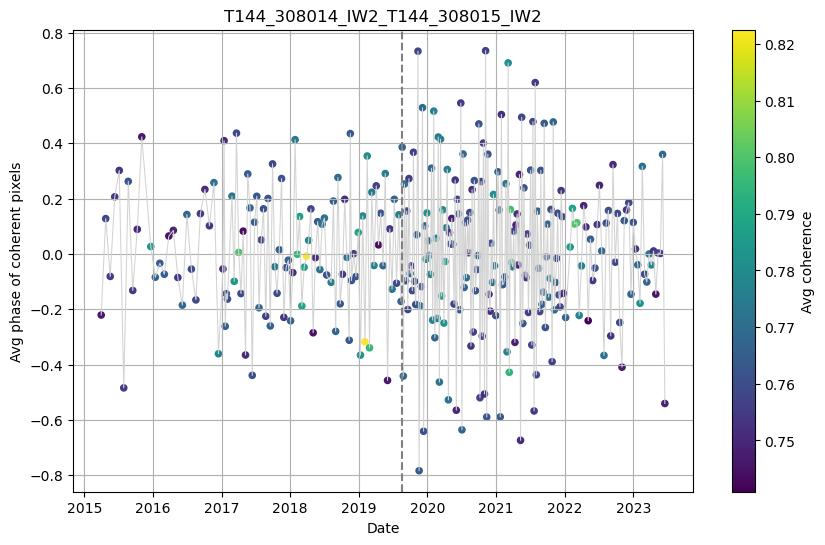

In [5]:
plt.figure(figsize=(10,6))
plt.plot(datesdt,topavg,'lightgrey',linewidth=.75)
plt.scatter(datesdt,topavg,s=20,c=topcohavg)
plt.axvline(x=datesdt[107],linestyle='dashed',color='gray') # denotes start of S1b
plt.grid()
plt.xlabel('Date')
plt.ylabel('Avg phase of coherent pixels')
plt.title('T144_308014_IW2_T144_308015_IW2')
plt.colorbar(label='Avg coherence')
plt.show()

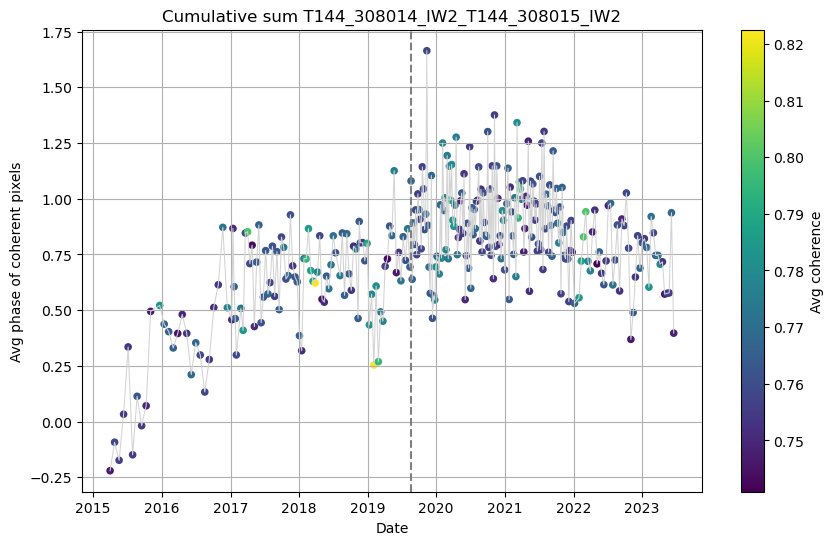

In [6]:
plt.figure(figsize=(10,6))
plt.plot(datesdt,np.cumsum(topavg),'lightgrey',linewidth=.75)
plt.scatter(datesdt,np.cumsum(topavg),s=20,c=topcohavg)
plt.axvline(x=datesdt[107],linestyle='dashed',color='gray') # denotes start of S1b
plt.grid()
plt.xlabel('Date')
plt.ylabel('Avg phase of coherent pixels')
plt.title('Cumulative sum T144_308014_IW2_T144_308015_IW2')
plt.colorbar(label='Avg coherence')
plt.show()

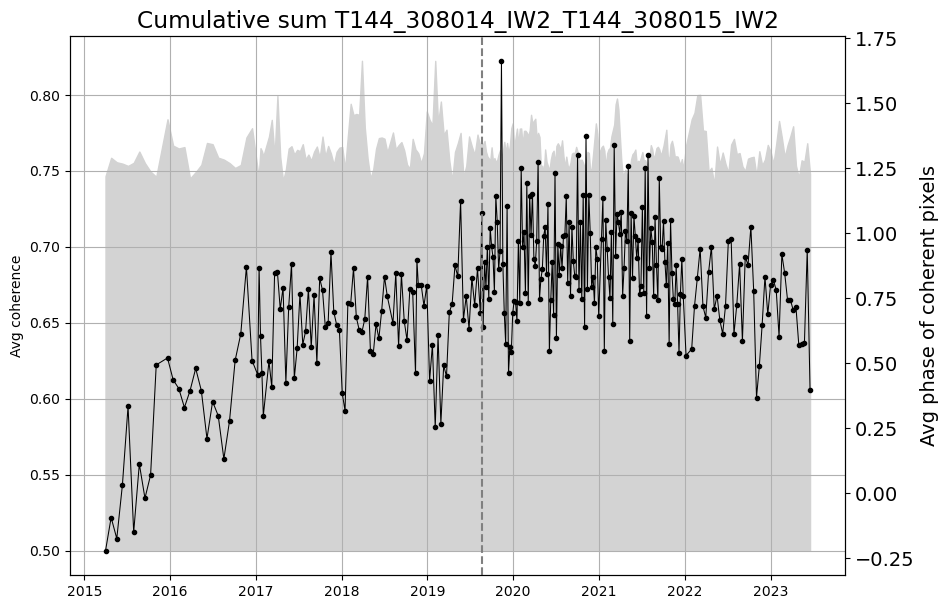

In [7]:
fig, ax1 = plt.subplots(figsize=(10,7))
plt.rcParams['font.size'] = 14
ax1.fill_between(datesdt,topcohavg,y2=.5,color='lightgray')
ax1.set_ylabel('Avg coherence')
plt.grid()
ax2 = ax1.twinx()
ax2.plot(datesdt,np.cumsum(topavg),'.-k',linewidth=.75)
ax2.axvline(x=datesdt[107],linestyle='dashed',color='gray') # denotes start of S1b
ax2.set_xlabel('Date')
ax2.set_ylabel('Avg phase of coherent pixels')
plt.title('Cumulative sum T144_308014_IW2_T144_308015_IW2')
plt.show()

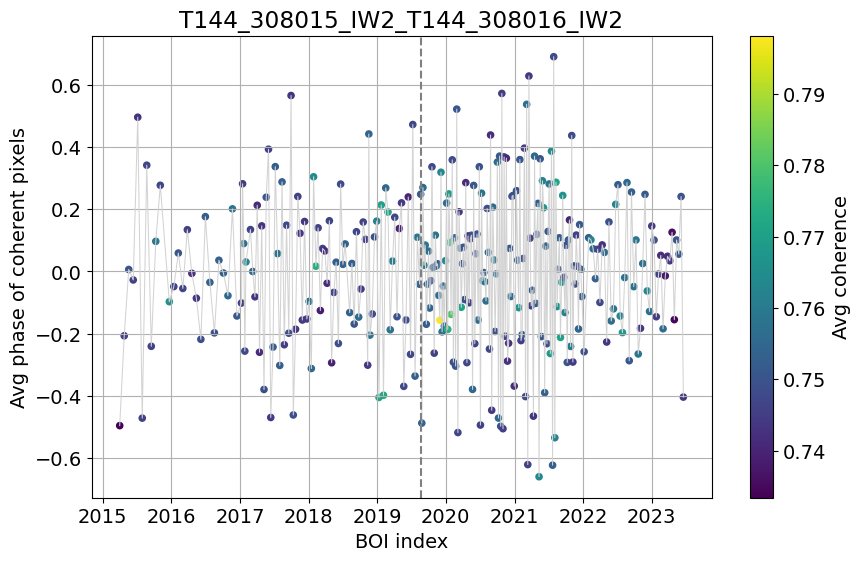

In [8]:
plt.figure(figsize=(10,6))
plt.plot(datesdt,botavg,'lightgrey',linewidth=.75)
plt.scatter(datesdt,botavg,s=20,c=botcohavg)
plt.axvline(x=datesdt[107],linestyle='dashed',color='gray') # denotes start of S1b
plt.grid()
plt.xlabel('BOI index')
plt.ylabel('Avg phase of coherent pixels')
plt.title('T144_308015_IW2_T144_308016_IW2')
plt.colorbar(label='Avg coherence')
plt.show()

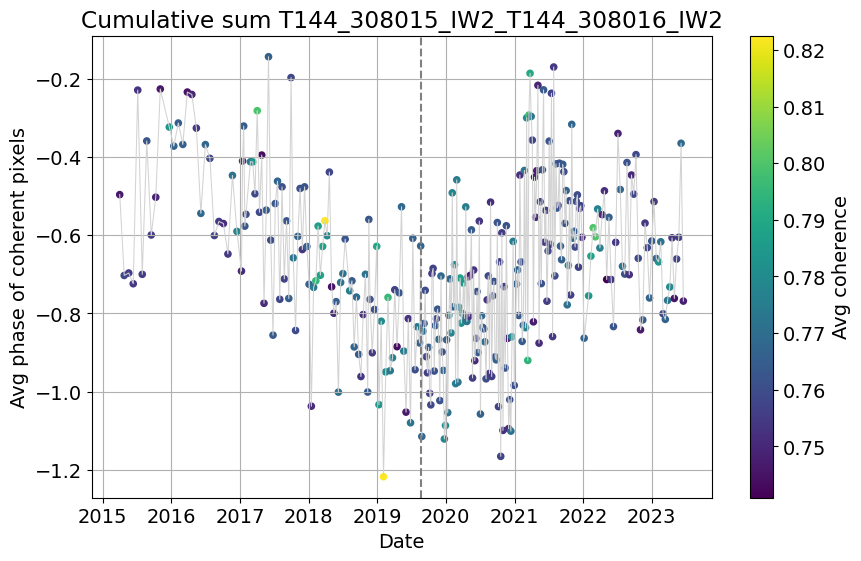

In [9]:
plt.figure(figsize=(10,6))
plt.plot(datesdt,np.cumsum(botavg),'lightgrey',linewidth=.75)
plt.scatter(datesdt,np.cumsum(botavg),s=20,c=topcohavg)
plt.axvline(x=datesdt[107],linestyle='dashed',color='gray') # denotes start of S1b
plt.grid()
plt.xlabel('Date')
plt.ylabel('Avg phase of coherent pixels')
plt.title('Cumulative sum T144_308015_IW2_T144_308016_IW2')
plt.colorbar(label='Avg coherence')
plt.show()

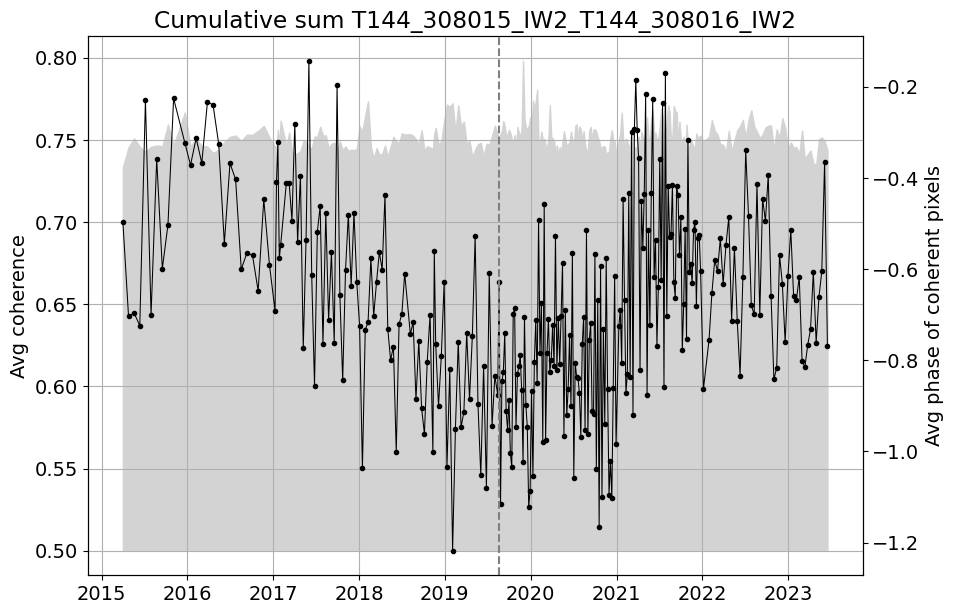

In [10]:
fig, ax1 = plt.subplots(figsize=(10,7))
plt.rcParams['font.size'] = 14
ax1.fill_between(datesdt,botcohavg,y2=.5,color='lightgray')
ax1.set_ylabel('Avg coherence')
plt.grid()
ax2 = ax1.twinx()
ax2.plot(datesdt,np.cumsum(botavg),'.-k',linewidth=.75)
ax2.axvline(x=datesdt[107],linestyle='dashed',color='gray') # denotes start of S1b
ax2.set_xlabel('Date')
ax2.set_ylabel('Avg phase of coherent pixels')
plt.title('Cumulative sum T144_308015_IW2_T144_308016_IW2')
plt.show()